# EDA & Feature Engineering - 2 Bulan

* Prasyarat:**
- Input: `dataset_rapi_2bulan.csv` (105.995 data bersih)
- Sudah memiliki: SLOT, ROW, TIER sebagai kolom terpisah (tidak perlu parsing!)
- Blok 7 sudah difilter pada tahap pembersihan


## 1. Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

✅ Libraries imported successfully!
Pandas version: 2.2.2
Numpy version: 1.26.4


In [2]:
print("=" * 80)
print("DATASET LOADED")
print("=" * 80)

# Load cleaned 2-month dataset
df = pd.read_csv('../Data/processed/dataset_rapi_2bulan.csv')

print(f"\n✅ Dataset loaded successfully!")
print(f"   Shape: {df.shape}")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {df.shape[1]}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n📊 Columns:")
print(df.columns.tolist())

DATASET LOADED

✅ Dataset loaded successfully!
   Shape: (105995, 22)
   Rows: 105,995
   Columns: 22
   Memory: 90.13 MB

📊 Columns:
['TRUCK_ID', 'JOB_TYPE', 'CONTAINER_KEY', 'CONTAINER_SIZE', 'CTR_STATUS', 'CONTAINER_TYPE', 'CONTAINER_NO', 'GATE_IN', 'PARKING_IN', 'PARKING_OUT', 'BUFFER_IN', 'STACK_TIME', 'SLOT', 'ROW', 'TIER', 'STACK', 'BUFFER_OUT', 'GATE_OUT', 'GATE_IN_STACK', 'GATE_IN_OUT', 'PARK_IN_OUT', 'GATE_IN_PARK_OUT']


## 2. Data Preparation & Cleaning

In [3]:
print("=" * 80)
print("DATETIME CONVERSION")
print("=" * 80)

# Convert datetime columns
datetime_cols = ['GATE_IN', 'PARKING_IN', 'PARKING_OUT', 'BUFFER_IN', 
                 'STACK_TIME', 'BUFFER_OUT', 'GATE_OUT']

for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"   ✅ {col} converted to datetime")

print("\n✅ All datetime columns converted!")

DATETIME CONVERSION
   ✅ GATE_IN converted to datetime
   ✅ PARKING_IN converted to datetime
   ✅ PARKING_OUT converted to datetime
   ✅ BUFFER_IN converted to datetime
   ✅ STACK_TIME converted to datetime
   ✅ BUFFER_OUT converted to datetime
   ✅ GATE_OUT converted to datetime

✅ All datetime columns converted!


In [4]:
print("=" * 80)
print("FILTERING DATA")
print("=" * 80)

print(f"\nOriginal records: {len(df):,}")

# Remove rows where target is null
df_clean = df[df['GATE_IN_STACK'].notna()].copy()
print(f"After removing null GATE_IN_STACK: {len(df_clean):,}")

# Remove negative values
df_clean = df_clean[df_clean['GATE_IN_STACK'] >= 0].copy()
print(f"After removing negative values: {len(df_clean):,}")

print(f"\n📊 Target variable stats:")
print(f"   Mean: {df_clean['GATE_IN_STACK'].mean():.2f} minutes")
print(f"   Median: {df_clean['GATE_IN_STACK'].median():.2f} minutes")
print(f"   Std: {df_clean['GATE_IN_STACK'].std():.2f} minutes")
print(f"   Min: {df_clean['GATE_IN_STACK'].min():.2f} minutes")
print(f"   Max: {df_clean['GATE_IN_STACK'].max():.2f} minutes")

FILTERING DATA

Original records: 105,995
After removing null GATE_IN_STACK: 103,198
After removing negative values: 102,649

📊 Target variable stats:
   Mean: 17.71 minutes
   Median: 13.37 minutes
   Std: 13.69 minutes
   Min: 0.43 minutes
   Max: 521.85 minutes


In [5]:
print("=" * 80)
print("OUTLIER REMOVAL (Q5-Q99)")
print("=" * 80)

# Calculate quantiles
q05 = df_clean['GATE_IN_STACK'].quantile(0.05)
q99 = df_clean['GATE_IN_STACK'].quantile(0.99)

print(f"\nQuantiles:")
print(f"   Q5:  {q05:.2f} minutes")
print(f"   Q99: {q99:.2f} minutes")

# Filter to Q5-Q99 range
mask = (df_clean['GATE_IN_STACK'] >= q05) & (df_clean['GATE_IN_STACK'] <= q99)
df_clean = df_clean[mask].copy()

print(f"\nAfter outlier removal: {len(df_clean):,} records")
print(f"\n📊 Final target stats:")
print(f"   Mean:   {df_clean['GATE_IN_STACK'].mean():.2f} minutes")
print(f"   Median: {df_clean['GATE_IN_STACK'].median():.2f} minutes")
print(f"   Std:    {df_clean['GATE_IN_STACK'].std():.2f} minutes")
print(f"   Min:    {df_clean['GATE_IN_STACK'].min():.2f} minutes")
print(f"   Max:    {df_clean['GATE_IN_STACK'].max():.2f} minutes")

OUTLIER REMOVAL (Q5-Q99)

Quantiles:
   Q5:  7.35 minutes
   Q99: 70.85 minutes

After outlier removal: 96,496 records

📊 Final target stats:
   Mean:   17.49 minutes
   Median: 13.70 minutes
   Std:    10.52 minutes
   Min:    7.35 minutes
   Max:    70.83 minutes


## 3. Feature Engineering 

### 3.1 Location Features (Slot, Row, Tier, Block)

** SIMPLIFIED: Dataset 2 bulan sudah punya SLOT, ROW, TIER terpisah!**

In [6]:
print("=" * 80)
print("SECTION 1: LOCATION FEATURES")
print("=" * 80)

# ✅ CRITICAL FIX: Clean and format location columns as STRINGS (for categorical encoding)
df_clean['slot'] = df_clean['SLOT'].astype(str).str.strip()
df_clean['row'] = df_clean['ROW'].astype(str).str.strip()
df_clean['tier'] = df_clean['TIER'].astype(str).str.strip()

# ✅ CRITICAL FIX: Clean block (STACK column) - NO TRAILING SPACES!
df_clean['block'] = df_clean['STACK'].astype(str).str.strip()

# Create numeric versions for calculations
df_clean['slot_numeric'] = pd.to_numeric(df_clean['slot'], errors='coerce').fillna(0).astype(int)
df_clean['row_numeric'] = pd.to_numeric(df_clean['row'], errors='coerce').fillna(0).astype(int)
df_clean['tier_numeric'] = pd.to_numeric(df_clean['tier'], errors='coerce').fillna(0).astype(int)

# Extract block number (e.g., '1G' -> 1)
df_clean['block_numeric'] = df_clean['block'].str.extract(r'(\d+)').astype(float).fillna(0).astype(int)

# Distance features
df_clean['distance_from_gate'] = (
    df_clean['slot_numeric'] * 10 + 
    df_clean['row_numeric'] * 2 + 
    df_clean['tier_numeric'] * 3
)

df_clean['vertical_distance'] = df_clean['tier_numeric'] ** 2

print(f"\n✅ Location features created:")
print(f"   - slot: {df_clean['slot'].nunique()} unique slots")
print(f"   - tier: {df_clean['tier'].nunique()} unique tiers")
print(f"   - block: {df_clean['block'].nunique()} unique blocks")
print(f"\n   Sample slot values: {df_clean['slot'].unique()[:5].tolist()}")
print(f"   Sample tier values: {df_clean['tier'].unique()[:5].tolist()}")
print(f"   Sample block values: {df_clean['block'].unique()[:5].tolist()}")
print(f"\n   ✅ NO TRAILING SPACES in block values!")

SECTION 1: LOCATION FEATURES

✅ Location features created:
   - slot: 100 unique slots
   - tier: 7 unique tiers
   - block: 24 unique blocks

   Sample slot values: ['26.0', '14.0', '38.0', '73.0', '19.0']
   Sample tier values: ['3.0', '2.0', '5.0', '4.0', '1.0']
   Sample block values: ['5B', '1F', '5G', '1A', '4B']

   ✅ NO TRAILING SPACES in block values!


### 3.2 Temporal Features

In [7]:
print("=" * 80)
print("SECTION 2: TEMPORAL FEATURES")
print("=" * 80)

# Extract temporal features from GATE_IN
df_clean['gate_in_hour'] = df_clean['GATE_IN'].dt.hour
df_clean['gate_in_dayofweek'] = df_clean['GATE_IN'].dt.dayofweek
df_clean['gate_in_day'] = df_clean['GATE_IN'].dt.day
df_clean['gate_in_month'] = df_clean['GATE_IN'].dt.month
df_clean['gate_in_is_weekend'] = (df_clean['gate_in_dayofweek'] >= 5).astype(int)

# Peak hours (14:00 - 21:00)
df_clean['gate_in_is_peak'] = ((df_clean['gate_in_hour'] >= 14) & 
                                (df_clean['gate_in_hour'] <= 21)).astype(int)

# ✅ SHIFT DEFINITION: 8 shifts per day (3-hour blocks)
# shift_1: 00-03, shift_2: 03-06, ..., shift_8: 21-24
df_clean['shift_index'] = df_clean['gate_in_hour'] // 3
df_clean['gate_in_shift'] = 'shift_' + (df_clean['shift_index'] + 1).astype(str)

print(f"\n✅ Temporal features created:")
print(f"   - gate_in_hour: {df_clean['gate_in_hour'].min()} to {df_clean['gate_in_hour'].max()}")
print(f"   - gate_in_dayofweek: {df_clean['gate_in_dayofweek'].min()} to {df_clean['gate_in_dayofweek'].max()}")
print(f"   - gate_in_shift: {df_clean['gate_in_shift'].nunique()} unique shifts")
print(f"   - Sample shifts: {sorted(df_clean['gate_in_shift'].unique())}")

SECTION 2: TEMPORAL FEATURES

✅ Temporal features created:
   - gate_in_hour: 0 to 23
   - gate_in_dayofweek: 0 to 6
   - gate_in_shift: 8 unique shifts
   - Sample shifts: ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6', 'shift_7', 'shift_8']


VISUALIZATION: TEMPORAL FEATURES


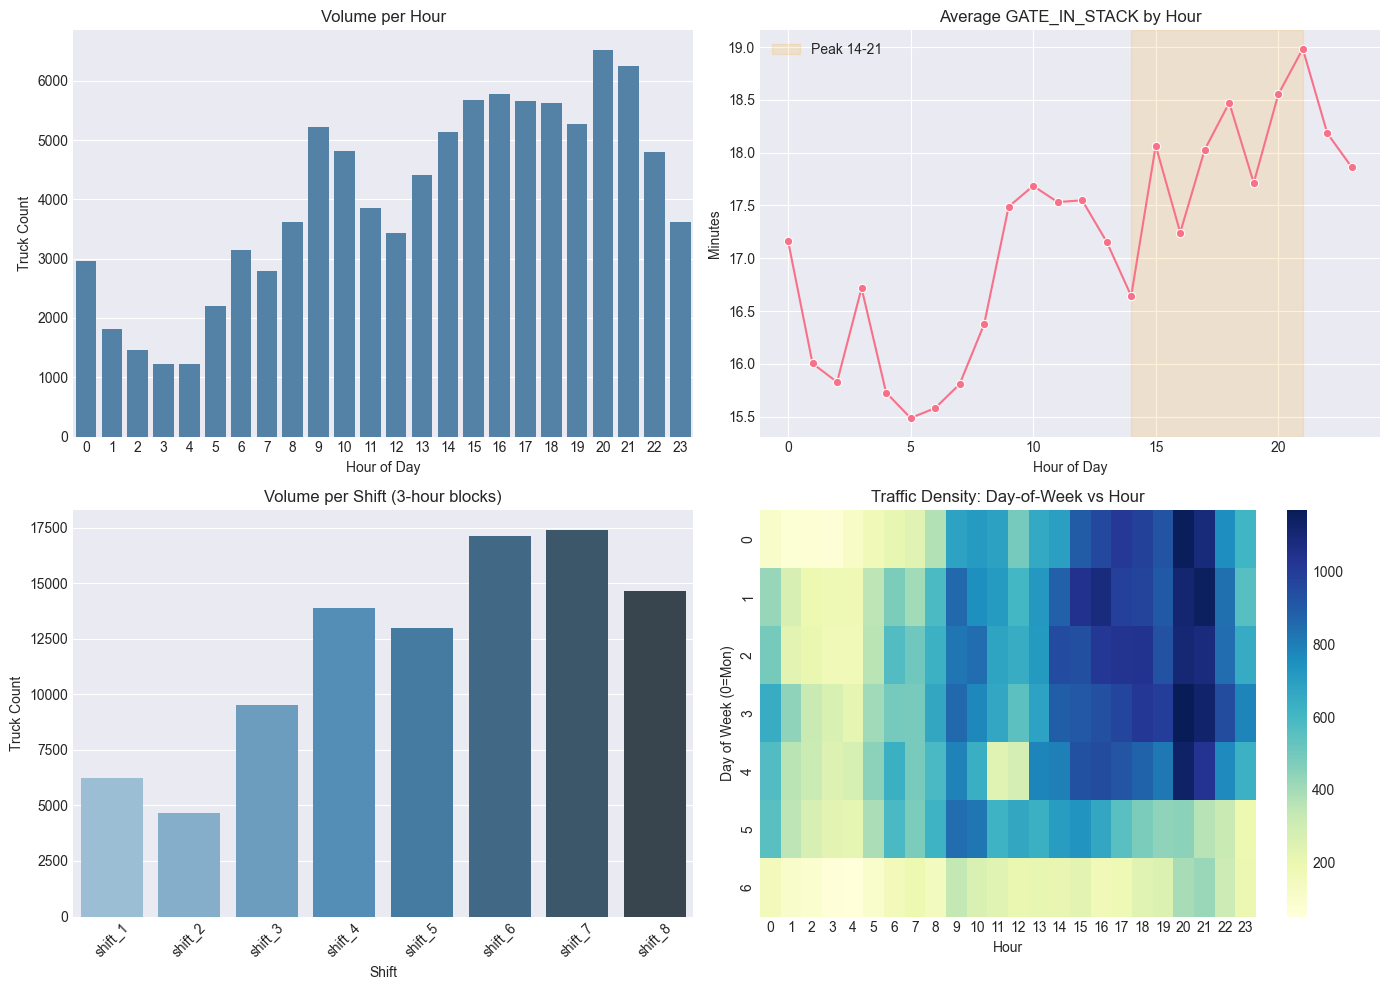

In [8]:
print("=" * 80)
print("VISUALIZATION: TEMPORAL FEATURES")
print("=" * 80)

# Quick visuals to make temporal patterns easier to present
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Volume per hour
hour_counts = df_clean['gate_in_hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values, ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Volume per Hour")
axes[0, 0].set_xlabel("Hour of Day")
axes[0, 0].set_ylabel("Truck Count")

# 2) Average duration per hour
hour_mean = df_clean.groupby('gate_in_hour')['GATE_IN_STACK'].mean()
sns.lineplot(x=hour_mean.index, y=hour_mean.values, marker="o", ax=axes[0, 1])
axes[0, 1].axvspan(14, 21, color='orange', alpha=0.15, label='Peak 14-21')
axes[0, 1].set_title("Average GATE_IN_STACK by Hour")
axes[0, 1].set_xlabel("Hour of Day")
axes[0, 1].set_ylabel("Minutes")
axes[0, 1].legend()

# 3) Volume per shift
shift_order = sorted(df_clean['gate_in_shift'].unique(), key=lambda s: int(s.split('_')[1]))
shift_counts = df_clean['gate_in_shift'].value_counts().reindex(shift_order)
sns.barplot(x=shift_counts.index, y=shift_counts.values, ax=axes[1, 0], palette="Blues_d")
axes[1, 0].set_title("Volume per Shift (3-hour blocks)")
axes[1, 0].set_xlabel("Shift")
axes[1, 0].set_ylabel("Truck Count")
axes[1, 0].tick_params(axis='x', rotation=45)

# 4) Heatmap Day-of-Week vs Hour
heatmap_data = df_clean.groupby(['gate_in_dayofweek', 'gate_in_hour'])['TRUCK_ID'].count().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap="YlGnBu", ax=axes[1, 1])
axes[1, 1].set_title("Traffic Density: Day-of-Week vs Hour")
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("Day of Week (0=Mon)")

plt.tight_layout()
plt.show()

**1️⃣ Hour (Jam) - 0 sampai 23:**
- `0` = Jam 00:00 (tengah malam / midnight)
- `1` = Jam 01:00 (dini hari)
- `12` = Jam 12:00 (siang / noon)
- `14` = Jam 14:00 (2 siang) ← **Mulai peak hour**
- `21` = Jam 21:00 (9 malam) ← **Akhir peak hour**
- `23` = Jam 23:00 (11 malam)

**Jadi hour 14-21 = Jam 2 siang sampai jam 9 malam**

---

**2️⃣ Day of Week (Hari dalam Minggu) - 0 sampai 6:**
- `0` = **Senin** (Monday)
- `1` = Selasa (Tuesday)
- `2` = Rabu (Wednesday)
- `3` = Kamis (Thursday)
- `4` = Jumat (Friday)
- `5` = Sabtu (Saturday) ← **Weekend mulai**
- `6` = Minggu (Sunday) ← **Weekend**

**Jadi 0 = Senin (hari kerja pertama), 6 = Minggu**

---

**3️⃣ Shift (8 shift per hari, masing-masing 3 jam):**
- `shift_1` = Jam 00:00 - 02:59 (tengah malam)
- `shift_2` = Jam 03:00 - 05:59 (subuh)
- `shift_3` = Jam 06:00 - 08:59 (pagi)
- `shift_4` = Jam 09:00 - 11:59 (siang)
- `shift_5` = Jam 12:00 - 14:59 (sore awal)
- `shift_6` = Jam 15:00 - 17:59 (sore)
- `shift_7` = Jam 18:00 - 20:59 (malam)
- `shift_8` = Jam 21:00 - 23:59 (malam akhir)

---

### 3.3 Rush Hour Features

In [9]:
print("=" * 80)
print("SECTION 3: RUSH HOUR FEATURES")
print("=" * 80)

# Morning rush: 08:00 - 10:00
df_clean['is_morning_rush'] = df_clean['gate_in_hour'].isin([8, 9, 10]).astype(int)

# Afternoon rush: 13:00 - 15:00
df_clean['is_afternoon_rush'] = df_clean['gate_in_hour'].isin([13, 14, 15]).astype(int)

# Combined rush hour
df_clean['is_rush_hour'] = ((df_clean['is_morning_rush'] == 1) | 
                            (df_clean['is_afternoon_rush'] == 1)).astype(int)

print(f"\n✅ Rush hour features created:")
print(f"   - Morning rush trucks: {df_clean['is_morning_rush'].sum():,}")
print(f"   - Afternoon rush trucks: {df_clean['is_afternoon_rush'].sum():,}")
print(f"   - Total rush hour trucks: {df_clean['is_rush_hour'].sum():,}")

SECTION 3: RUSH HOUR FEATURES

✅ Rush hour features created:
   - Morning rush trucks: 13,644
   - Afternoon rush trucks: 15,226
   - Total rush hour trucks: 28,870


### 3.4 Container Features

In [10]:
print("=" * 80)
print("SECTION 4: CONTAINER FEATURES")
print("=" * 80)

# Container size as numeric
df_clean['container_size_numeric'] = pd.to_numeric(df_clean['CONTAINER_SIZE'], errors='coerce').fillna(20)

# Container status binary features
df_clean['is_empty'] = (df_clean['CTR_STATUS'] == 'MTY').astype(int)
df_clean['is_full'] = (df_clean['CTR_STATUS'] == 'FCL').astype(int)

# Container type features
df_clean['is_reefer'] = df_clean['CONTAINER_TYPE'].str.contains('RF', na=False).astype(int)
df_clean['is_special'] = (~df_clean['CONTAINER_TYPE'].isin(['DRY', 'STANDARD'])).astype(int)

print(f"\n✅ Container features created:")
print(f"   - Container sizes: {sorted(df_clean['container_size_numeric'].unique())}")
print(f"   - Empty containers: {df_clean['is_empty'].sum():,}")
print(f"   - Full containers: {df_clean['is_full'].sum():,}")
print(f"   - Reefer containers: {df_clean['is_reefer'].sum():,}")
print(f"   - Special containers: {df_clean['is_special'].sum():,}")

SECTION 4: CONTAINER FEATURES

✅ Container features created:
   - Container sizes: [20, 40, 45]
   - Empty containers: 12,851
   - Full containers: 83,645
   - Reefer containers: 617
   - Special containers: 1,265


### 3.5 Congestion Features

In [11]:
print("=" * 80)
print("SECTION 5: CONGESTION FEATURES")
print("=" * 80)

# Hourly volume (trucks per hour)
hourly_counts = df_clean.groupby('gate_in_hour')['TRUCK_ID'].count()
df_clean['hourly_volume'] = df_clean['gate_in_hour'].map(hourly_counts)

# Congestion count (hour + slot combination)
df_clean['hour_slot'] = df_clean['gate_in_hour'].astype(str) + '_' + df_clean['slot']
congestion_counts = df_clean.groupby('hour_slot')['TRUCK_ID'].count()
df_clean['congestion_count'] = df_clean['hour_slot'].map(congestion_counts)

print(f"\n✅ Congestion features created:")
print(f"   - Hourly volume range: {df_clean['hourly_volume'].min():.0f} - {df_clean['hourly_volume'].max():.0f}")
print(f"   - Congestion count range: {df_clean['congestion_count'].min():.0f} - {df_clean['congestion_count'].max():.0f}")

SECTION 5: CONGESTION FEATURES

✅ Congestion features created:
   - Hourly volume range: 1217 - 6525
   - Congestion count range: 1 - 336


### 3.6 Historical Average Features

In [12]:
print("=" * 80)
print("SECTION 6: HISTORICAL AVERAGE FEATURES")
print("=" * 80)

# Slot historical average
slot_avg = df_clean.groupby('slot')['GATE_IN_STACK'].mean()
df_clean['slot_historical_avg'] = df_clean['slot'].map(slot_avg)

# Tier historical average
tier_avg = df_clean.groupby('tier')['GATE_IN_STACK'].mean()
df_clean['tier_historical_avg'] = df_clean['tier'].map(tier_avg)

# Location (slot-row-tier) historical average
df_clean['location_key'] = df_clean['slot'] + '_' + df_clean['row'] + '_' + df_clean['tier']
lokasi_avg = df_clean.groupby('location_key')['GATE_IN_STACK'].mean()
df_clean['lokasi_historical_avg'] = df_clean['location_key'].map(lokasi_avg)

# Hour historical average
hour_avg = df_clean.groupby('gate_in_hour')['GATE_IN_STACK'].mean()
df_clean['hour_historical_avg'] = df_clean['gate_in_hour'].map(hour_avg)

print(f"\n✅ Historical features created:")
print(f"   - slot_historical_avg: {df_clean['slot_historical_avg'].mean():.2f} min (avg)")
print(f"   - tier_historical_avg: {df_clean['tier_historical_avg'].mean():.2f} min (avg)")
print(f"   - lokasi_historical_avg: {df_clean['lokasi_historical_avg'].mean():.2f} min (avg)")
print(f"   - hour_historical_avg: {df_clean['hour_historical_avg'].mean():.2f} min (avg)")

SECTION 6: HISTORICAL AVERAGE FEATURES

✅ Historical features created:
   - slot_historical_avg: 17.49 min (avg)
   - tier_historical_avg: 17.49 min (avg)
   - lokasi_historical_avg: 17.49 min (avg)
   - hour_historical_avg: 17.49 min (avg)


### 3.7 Interaction Features

In [13]:
print("=" * 80)
print("SECTION 7: INTERACTION FEATURES ")
print("=" * 80)

# Use multiplication, NOT string concatenation!

# 1. Slot-Tier interaction (NUMERICAL)
df_clean['slot_tier_interaction'] = df_clean['slot_numeric'] * df_clean['tier_numeric']
# Example: slot 14, tier 2 → 14 * 2 = 28 (continuous number)

# 2. Size-Tier interaction (NUMERICAL)
df_clean['size_tier_interaction'] = df_clean['container_size_numeric'] * df_clean['tier_numeric']
# Example: size 40, tier 2 → 40 * 2 = 80 (continuous number)

# 3. Congestion-Tier interaction (NUMERICAL)
df_clean['congestion_tier'] = df_clean['congestion_count'] * df_clean['tier_numeric']

# 4. Rush Hour-Congestion interaction (NUMERICAL)
df_clean['rush_hour_congestion'] = df_clean['is_rush_hour'] * df_clean['congestion_count']

print(f"\n✅ Interaction features created (ALL NUMERICAL!):")
print(f"   - slot_tier_interaction: range {df_clean['slot_tier_interaction'].min():.0f} - {df_clean['slot_tier_interaction'].max():.0f}")
print(f"   - size_tier_interaction: range {df_clean['size_tier_interaction'].min():.0f} - {df_clean['size_tier_interaction'].max():.0f}")
print(f"   - congestion_tier: range {df_clean['congestion_tier'].min():.0f} - {df_clean['congestion_tier'].max():.0f}")
print(f"   - rush_hour_congestion: range {df_clean['rush_hour_congestion'].min():.0f} - {df_clean['rush_hour_congestion'].max():.0f}")
print(f"\n   🎯 NO STRING CONCATENATION - ALL NUMERICAL!")

SECTION 7: INTERACTION FEATURES 

✅ Interaction features created (ALL NUMERICAL!):
   - slot_tier_interaction: range 1 - 420
   - size_tier_interaction: range 20 - 280
   - congestion_tier: range 1 - 2016
   - rush_hour_congestion: range 0 - 267

   🎯 NO STRING CONCATENATION - ALL NUMERICAL!


### 3.8 Statistical Features (by Slot)

In [14]:
print("=" * 80)
print("SECTION 8: STATISTICAL FEATURES")
print("=" * 80)

# Statistical measures by slot
df_clean['slot_duration_std'] = df_clean.groupby('slot')['GATE_IN_STACK'].transform('std')
df_clean['slot_duration_min'] = df_clean.groupby('slot')['GATE_IN_STACK'].transform('min')
df_clean['slot_duration_max'] = df_clean.groupby('slot')['GATE_IN_STACK'].transform('max')

# Fill NaN for slots with single record (std = NaN)
df_clean['slot_duration_std'].fillna(0, inplace=True)

print(f"\n✅ Statistical features created:")
print(f"   - slot_duration_std: mean={df_clean['slot_duration_std'].mean():.2f}")
print(f"   - slot_duration_min: mean={df_clean['slot_duration_min'].mean():.2f}")
print(f"   - slot_duration_max: mean={df_clean['slot_duration_max'].mean():.2f}")

SECTION 8: STATISTICAL FEATURES

✅ Statistical features created:
   - slot_duration_std: mean=10.35
   - slot_duration_min: mean=7.36
   - slot_duration_max: mean=69.22


### 3.9 Lag Features (Time Series)

In [15]:
print("=" * 80)
print("SECTION 9: LAG FEATURES (Time Series Patterns)")
print("=" * 80)

# Sort by location and time for lag features
df_clean = df_clean.sort_values(['location_key', 'GATE_IN'])

# Previous duration at same exact location
df_clean['prev_duration_same_location'] = df_clean.groupby('location_key')['GATE_IN_STACK'].shift(1)

# Rolling mean of last 3 trucks at same location
df_clean['rolling_mean_3'] = df_clean.groupby('location_key')['GATE_IN_STACK'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Fill NaN with global mean
global_mean = df_clean['GATE_IN_STACK'].mean()
df_clean['prev_duration_same_location'].fillna(global_mean, inplace=True)
df_clean['rolling_mean_3'].fillna(global_mean, inplace=True)

print(f"\n✅ Lag features created:")
print(f"   - prev_duration_same_location: mean={df_clean['prev_duration_same_location'].mean():.2f} min")
print(f"   - rolling_mean_3: mean={df_clean['rolling_mean_3'].mean():.2f} min")
print(f"\n   📝 Note: Uses only PAST data - NO DATA LEAKAGE!")

SECTION 9: LAG FEATURES (Time Series Patterns)

✅ Lag features created:
   - prev_duration_same_location: mean=17.45 min
   - rolling_mean_3: mean=17.45 min

   📝 Note: Uses only PAST data - NO DATA LEAKAGE!


### 3.10 Target Encoding Features

In [16]:
print("=" * 80)
print("SECTION 10: TARGET ENCODING")
print("=" * 80)

# Block target encoding
df_clean['BLOCK_target_enc'] = df_clean.groupby('block')['GATE_IN_STACK'].transform('mean')

# Location target encoding
df_clean['LOKASI_target_enc'] = df_clean.groupby('location_key')['GATE_IN_STACK'].transform('mean')

print(f"\n✅ Target encoding features created:")
print(f"   - BLOCK_target_enc: mean={df_clean['BLOCK_target_enc'].mean():.2f}")
print(f"   - LOKASI_target_enc: mean={df_clean['LOKASI_target_enc'].mean():.2f}")

SECTION 10: TARGET ENCODING

✅ Target encoding features created:
   - BLOCK_target_enc: mean=17.49
   - LOKASI_target_enc: mean=17.49


## 4. Feature Summary 

In [17]:
print("=" * 80)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 80)
print("\n✅ All features created successfully!\n")

feature_breakdown = {
    "1. Categorical (8)": [
        "JOB_TYPE", "CONTAINER_SIZE", "CTR_STATUS", "CONTAINER_TYPE",
        "slot", "tier", "block", "gate_in_shift"
    ],
    "2. Temporal (6)": [
        "gate_in_hour", "gate_in_dayofweek", "gate_in_day", "gate_in_month",
        "gate_in_is_weekend", "gate_in_is_peak"
    ],
    "3. Location/Distance (6)": [
        "slot_numeric", "row_numeric", "tier_numeric", "block_numeric",
        "distance_from_gate", "vertical_distance"
    ],
    "4. Congestion (2)": [
        "hourly_volume", "congestion_count"
    ],
    "5. Historical (4)": [
        "slot_historical_avg", "tier_historical_avg",
        "lokasi_historical_avg", "hour_historical_avg"
    ],
    "6. Container (5)": [
        "container_size_numeric", "is_empty", "is_full",
        "is_reefer", "is_special"
    ],
    "7. Rush Hour (3)": [
        "is_morning_rush", "is_afternoon_rush", "is_rush_hour"
    ],
    "8. Interactions (4 - ALL NUMERICAL!)": [
        "slot_tier_interaction", "size_tier_interaction",
        "congestion_tier", "rush_hour_congestion"
    ],
    "9. Statistical (3)": [
        "slot_duration_std", "slot_duration_min", "slot_duration_max"
    ],
    "10. Lag Features (2)": [
        "prev_duration_same_location", "rolling_mean_3"
    ],
    "11. Target Encoding (2)": [
        "BLOCK_target_enc", "LOKASI_target_enc"
    ]
}

for category, features in feature_breakdown.items():
    print(f"{category}:")
    for feat in features:
        print(f"  - {feat}")
    print()

total_features = sum(len(feats) for feats in feature_breakdown.values())
print(f"📊 TOTAL: {total_features} features + 1 target = {total_features + 1} columns")

FEATURE ENGINEERING COMPLETE!

✅ All features created successfully!

1. Categorical (8):
  - JOB_TYPE
  - CONTAINER_SIZE
  - CTR_STATUS
  - CONTAINER_TYPE
  - slot
  - tier
  - block
  - gate_in_shift

2. Temporal (6):
  - gate_in_hour
  - gate_in_dayofweek
  - gate_in_day
  - gate_in_month
  - gate_in_is_weekend
  - gate_in_is_peak

3. Location/Distance (6):
  - slot_numeric
  - row_numeric
  - tier_numeric
  - block_numeric
  - distance_from_gate
  - vertical_distance

4. Congestion (2):
  - hourly_volume
  - congestion_count

5. Historical (4):
  - slot_historical_avg
  - tier_historical_avg
  - lokasi_historical_avg
  - hour_historical_avg

6. Container (5):
  - container_size_numeric
  - is_empty
  - is_full
  - is_reefer
  - is_special

7. Rush Hour (3):
  - is_morning_rush
  - is_afternoon_rush
  - is_rush_hour

8. Interactions (4 - ALL NUMERICAL!):
  - slot_tier_interaction
  - size_tier_interaction
  - congestion_tier
  - rush_hour_congestion

9. Statistical (3):
  - slot_dura

### 4.1 Visualisasi Semua Features (untuk Presentasi)

Visualisasi komprehensif untuk membantu audiens memahami karakteristik setiap kategori feature.

VISUALISASI 1: TARGET VARIABLE & CATEGORICAL FEATURES


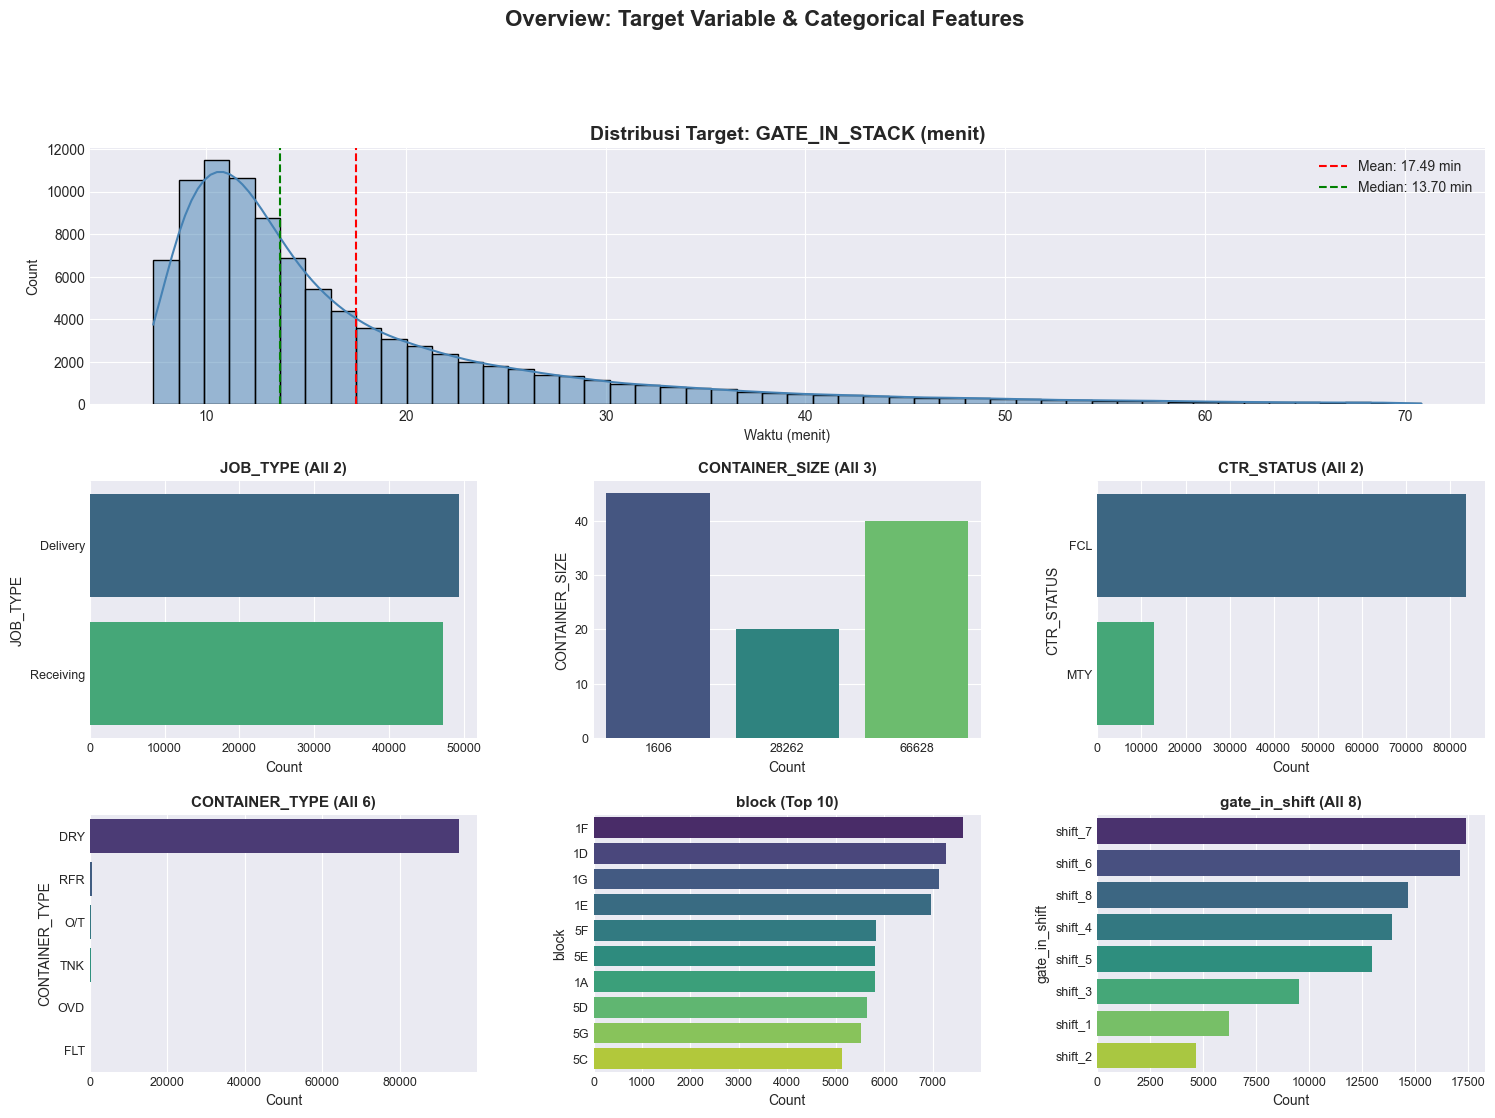


✅ Visualisasi 1 complete: Target & Categorical features


In [18]:
print("=" * 80)
print("VISUALISASI 1: TARGET VARIABLE & CATEGORICAL FEATURES")
print("=" * 80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Target Variable Distribution
ax1 = fig.add_subplot(gs[0, :])
sns.histplot(df_clean['GATE_IN_STACK'], bins=50, kde=True, ax=ax1, color='steelblue')
ax1.set_title('Distribusi Target: GATE_IN_STACK (menit)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Waktu (menit)')
ax1.axvline(df_clean['GATE_IN_STACK'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["GATE_IN_STACK"].mean():.2f} min')
ax1.axvline(df_clean['GATE_IN_STACK'].median(), color='green', linestyle='--', label=f'Median: {df_clean["GATE_IN_STACK"].median():.2f} min')
ax1.legend()

# 2-7. Top Categorical Features
categorical_features = ['JOB_TYPE', 'CONTAINER_SIZE', 'CTR_STATUS', 'CONTAINER_TYPE', 'block', 'gate_in_shift']
axes_pos = [(1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]

for idx, (cat_feat, pos) in enumerate(zip(categorical_features, axes_pos)):
    ax = fig.add_subplot(gs[pos])
    top_values = df_clean[cat_feat].value_counts().head(10)
    sns.barplot(x=top_values.values, y=top_values.index, ax=ax, palette='viridis')
    
    # Dynamic title based on number of unique values
    n_unique = df_clean[cat_feat].nunique()
    if n_unique > 10:
        title = f'{cat_feat} (Top 10)'
    else:
        title = f'{cat_feat} (All {n_unique})'
    
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Count')
    ax.tick_params(labelsize=9)

plt.suptitle('Overview: Target Variable & Categorical Features', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✅ Visualisasi 1 complete: Target & Categorical features")

## 5. Final Dataset Preparation

In [19]:
print("=" * 80)
print("FINAL DATASET PREPARATION")
print("=" * 80)

# Target variable
target_col = 'GATE_IN_STACK'

# All model features 
model_features = [
    # === CATEGORICAL (8) ===
    'JOB_TYPE', 'CONTAINER_SIZE', 'CTR_STATUS', 'CONTAINER_TYPE',
    'slot', 'tier', 'block', 'gate_in_shift',
    
    # === NUMERICAL (34) ===
    # Temporal (6)
    'gate_in_hour', 'gate_in_dayofweek', 'gate_in_day', 'gate_in_month',
    'gate_in_is_weekend', 'gate_in_is_peak',
    
    # Location/Distance (6)
    'slot_numeric', 'row_numeric', 'tier_numeric', 'block_numeric',
    'distance_from_gate', 'vertical_distance',
    
    # Congestion (2)
    'hourly_volume', 'congestion_count',
    
    # Historical (4)
    'slot_historical_avg', 'tier_historical_avg',
    'lokasi_historical_avg', 'hour_historical_avg',
    
    # Container (5)
    'container_size_numeric', 'is_empty', 'is_full',
    'is_reefer', 'is_special',
    
    # Rush Hour (3)
    'is_morning_rush', 'is_afternoon_rush', 'is_rush_hour',
    
    # Interactions - ALL NUMERICAL! (4)
    'slot_tier_interaction', 'size_tier_interaction',
    'congestion_tier', 'rush_hour_congestion',
    
    # Statistical (3)
    'slot_duration_std', 'slot_duration_min', 'slot_duration_max',
    
    # Lag (2)
    'prev_duration_same_location', 'rolling_mean_3',
    
    # Target Encoding (2)
    'BLOCK_target_enc', 'LOKASI_target_enc'
]

# Create final dataset
all_model_features = model_features + [target_col]
df_final = df_clean[all_model_features].copy()

# Check for missing values
missing_count = df_final.isnull().sum().sum()

if missing_count > 0:
    print(f"\n⚠️  Warning: {missing_count} missing values found!")
    print("\nMissing values by column:")
    print(df_final.isnull().sum()[df_final.isnull().sum() > 0])
    df_final = df_final.dropna()
    print(f"\nRows after dropping NaN: {len(df_final):,}")
else:
    print(f"\n✅ No missing values!")

print(f"\n📊 Final dataset shape: {df_final.shape}")
print(f"  Total features: {len(model_features)}")
print(f"  Total samples: {len(df_final):,}")

print(f"\n🎯 Target variable: {target_col}")
print(f"  Min: {df_final[target_col].min():.2f} menit")
print(f"  Max: {df_final[target_col].max():.2f} menit")
print(f"  Mean: {df_final[target_col].mean():.2f} menit")
print(f"  Median: {df_final[target_col].median():.2f} menit")
print(f"  Std: {df_final[target_col].std():.2f} menit")

FINAL DATASET PREPARATION

✅ No missing values!

📊 Final dataset shape: (96496, 46)
  Total features: 45
  Total samples: 96,496

🎯 Target variable: GATE_IN_STACK
  Min: 7.35 menit
  Max: 70.83 menit
  Mean: 17.49 menit
  Median: 13.70 menit
  Std: 10.52 menit


## 6. Save Final Dataset

In [20]:
print("=" * 80)
print("SAVING FINAL DATASET")
print("=" * 80)

# Create directory if doesn't exist
import os
os.makedirs('../Data/processed', exist_ok=True)

# Save to CSV
output_path = '../Data/processed/dataset_final2bulan_45FEATURES_PROPER.csv'
df_final.to_csv(output_path, index=False)

print(f"\n✅ Dataset saved successfully!")
print(f"   Path: {output_path}")
print(f"   Size: {os.path.getsize(output_path) / 1024**2:.2f} MB")
print(f"   Shape: {df_final.shape}")

print(f"\n" + "=" * 80)
print("✅ EDA & FEATURE ENGINEERING COMPLETE!")
print("=" * 80)

SAVING FINAL DATASET

✅ Dataset saved successfully!
   Path: ../Data/processed/dataset_final2bulan_45FEATURES_PROPER.csv
   Size: 25.29 MB
   Shape: (96496, 46)

✅ EDA & FEATURE ENGINEERING COMPLETE!


In [21]:
import pandas as pd

# Load dataset baru
df = pd.read_csv('../Data/processed/dataset_final2bulan_45FEATURES_PROPER.csv')

print(f"Records: {len(df):,}")
print(f"Max duration: {df['GATE_IN_STACK'].max():.2f} min")
print(f"Min duration: {df['GATE_IN_STACK'].min():.2f} min")
print(f"Mean duration: {df['GATE_IN_STACK'].mean():.2f} min")

# Check if Q99 (should be ~70.83)
if df['GATE_IN_STACK'].max() > 60:
    print("✅ Dataset Q5-Q99 tersave dengan benar!")
else:
    print("❌ ERROR: Dataset masih Q5-Q95!")

Records: 96,496
Max duration: 70.83 min
Min duration: 7.35 min
Mean duration: 17.49 min
✅ Dataset Q5-Q99 tersave dengan benar!
